Saving pngtree-simple-tree-with-lots-of-green-leaves-png-image_18352339.png to pngtree-simple-tree-with-lots-of-green-leaves-png-image_18352339.png


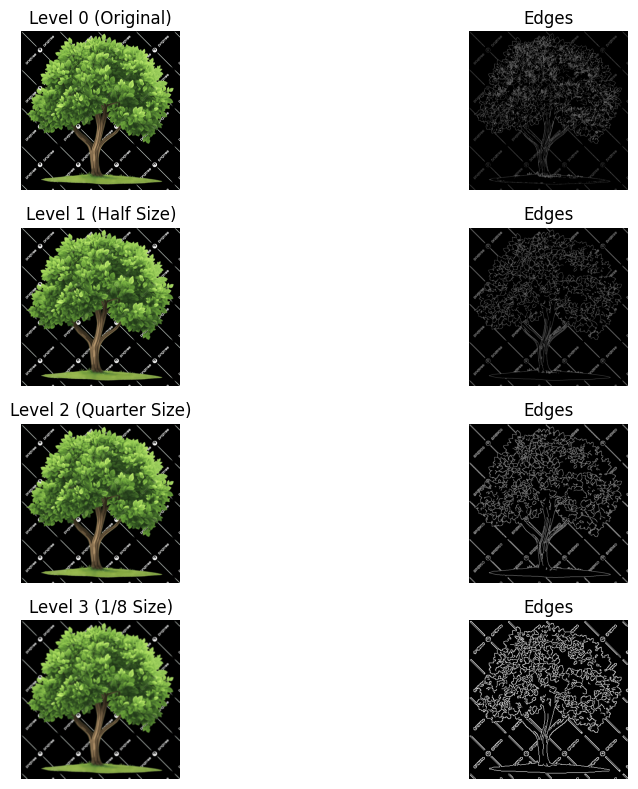

In [1]:
# Install OpenCV if needed
!pip install opencv-python

import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

# 1️⃣ Upload an image
uploaded = files.upload()

# Read uploaded image
image_path = list(uploaded.keys())[0]
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2️⃣ Generate Gaussian Pyramid
level0 = img
level1 = cv2.pyrDown(level0)   # Half size
level2 = cv2.pyrDown(level1)   # Quarter size
level3 = cv2.pyrDown(level2)   # One-eighth size

pyramid = [level0, level1, level2, level3]

# 3️⃣ Apply Canny Edge Detection at each level
edges = []
for level in pyramid:
    gray = cv2.cvtColor(level, cv2.COLOR_RGB2GRAY)
    edge = cv2.Canny(gray, 100, 200)
    edges.append(edge)

# 4️⃣ Display Results
titles = [
    "Level 0 (Original)",
    "Level 1 (Half Size)",
    "Level 2 (Quarter Size)",
    "Level 3 (1/8 Size)"
]

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(4, 2, 2*i + 1)
    plt.imshow(pyramid[i])
    plt.title(titles[i])
    plt.axis("off")

    plt.subplot(4, 2, 2*i + 2)
    plt.imshow(edges[i], cmap="gray")
    plt.title("Edges")
    plt.axis("off")

plt.tight_layout()
plt.show()


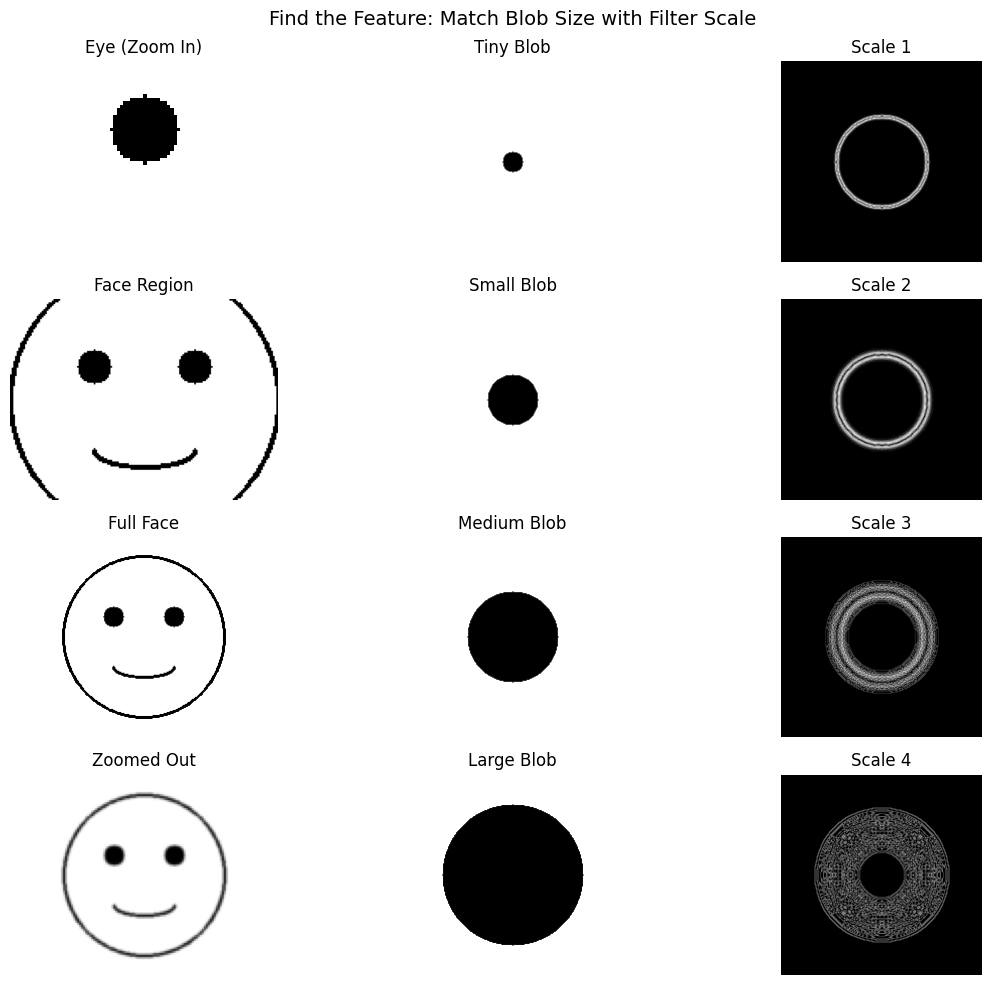

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Create blob images (Column B)
# -----------------------------
def create_blob(radius, size=200):
    img = np.ones((size, size), dtype=np.uint8) * 255
    cv2.circle(img, (size//2, size//2), radius, 0, -1)
    return img

blob_small = create_blob(10)
blob_medium = create_blob(25)
blob_large = create_blob(45)
blob_xlarge = create_blob(70)

blobs = [blob_small, blob_medium, blob_large, blob_xlarge]

# -----------------------------------------
# Apply Laplacian of Gaussian (Column C)
# -----------------------------------------
def apply_log(image, sigma):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    log = cv2.Laplacian(blurred, cv2.CV_64F)
    log = cv2.convertScaleAbs(log)
    return log

sigmas = [1, 2, 4, 8]
filters = [apply_log(blob_large, s) for s in sigmas]

# -----------------------------------------
# Column A: Object at different zoom levels
# -----------------------------------------
img = np.ones((200, 200), dtype=np.uint8) * 255
cv2.circle(img, (100, 100), 80, 0, 2)     # head
cv2.circle(img, (70, 80), 10, 0, -1)      # left eye
cv2.circle(img, (130, 80), 10, 0, -1)     # right eye
cv2.ellipse(img, (100, 130), (30, 10), 0, 0, 180, 0, 2)  # mouth

zoom1 = img[60:120, 40:100]   # eye region
zoom2 = img[40:160, 20:180]   # face
zoom3 = img                   # full head
zoom4 = cv2.pyrDown(img)      # zoomed out

zooms = [zoom1, zoom2, zoom3, zoom4]

# -----------------------------------------
# Display all columns
# -----------------------------------------
titlesA = ["Eye (Zoom In)", "Face Region", "Full Face", "Zoomed Out"]
titlesB = ["Tiny Blob", "Small Blob", "Medium Blob", "Large Blob"]
titlesC = ["Scale 1", "Scale 2", "Scale 3", "Scale 4"]

plt.figure(figsize=(12, 10))

# Column A
for i in range(4):
    plt.subplot(4, 3, 3*i + 1)
    plt.imshow(zooms[i], cmap='gray')
    plt.title(titlesA[i])
    plt.axis("off")

# Column B
for i in range(4):
    plt.subplot(4, 3, 3*i + 2)
    plt.imshow(blobs[i], cmap='gray')
    plt.title(titlesB[i])
    plt.axis("off")

# Column C
for i in range(4):
    plt.subplot(4, 3, 3*i + 3)
    plt.imshow(filters[i], cmap='gray')
    plt.title(titlesC[i])
    plt.axis("off")

plt.suptitle("Find the Feature: Match Blob Size with Filter Scale", fontsize=14)
plt.tight_layout()
plt.show()


Matches WITH scale invariance: 89
Matches WITHOUT scale handling: 69


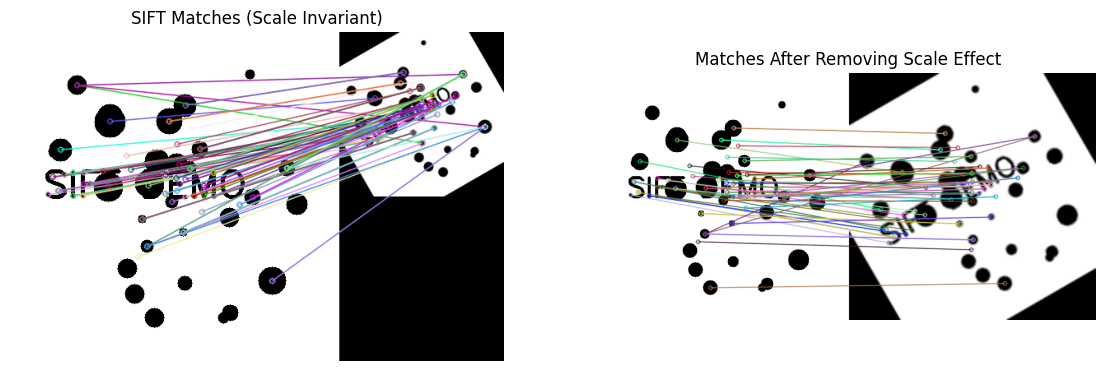

In [4]:
# Install required packages
!pip install opencv-python opencv-contrib-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Create a textured synthetic image (Object 1)
# -------------------------------------------------
img1 = np.ones((400, 400, 3), dtype=np.uint8) * 255

# Draw patterns for strong features
cv2.putText(img1, "SIFT DEMO", (40, 200),
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 3)

for i in range(30):
    cv2.circle(img1,
               (np.random.randint(50,350),
                np.random.randint(50,350)),
               np.random.randint(5,20),
               (0,0,0), -1)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# -------------------------------------------------
# 2. Create transformed version (scaled + rotated)
# -------------------------------------------------
scaled = cv2.resize(gray1, None, fx=0.5, fy=0.5)

rows, cols = scaled.shape
M = cv2.getRotationMatrix2D((cols//2, rows//2), 30, 1)
gray2 = cv2.warpAffine(scaled, M, (cols, rows))

# -------------------------------------------------
# 3. SIFT Feature Detection
# -------------------------------------------------
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# -------------------------------------------------
# 4. Match features (Scale Invariant)
# -------------------------------------------------
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

print("Matches WITH scale invariance:", len(good))

match_img = cv2.drawMatches(gray1, kp1,
                            gray2, kp2,
                            good, None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# -------------------------------------------------
# 5. Remove scale effect (resize manually)
# -------------------------------------------------
gray2_resized = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

kp1_ns, des1_ns = sift.detectAndCompute(gray1, None)
kp2_ns, des2_ns = sift.detectAndCompute(gray2_resized, None)

matches_ns = bf.knnMatch(des1_ns, des2_ns, k=2)

good_ns = []
for m, n in matches_ns:
    if m.distance < 0.75 * n.distance:
        good_ns.append(m)

print("Matches WITHOUT scale handling:", len(good_ns))

match_img_ns = cv2.drawMatches(gray1, kp1_ns,
                               gray2_resized, kp2_ns,
                               good_ns, None,
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# -------------------------------------------------
# 6. Display Results
# -------------------------------------------------
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(match_img, cmap='gray')
plt.title("SIFT Matches (Scale Invariant)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(match_img_ns, cmap='gray')
plt.title("Matches After Removing Scale Effect")
plt.axis("off")

plt.show()


Zoom Level | Mean Intensity | Variance
High       |         238.97 | 3831.32
Medium-1   |         238.96 | 2979.04
Medium-2   |         238.96 | 2084.42
Low-1      |         238.93 | 1058.64
Low-2      |         238.77 | 410.78


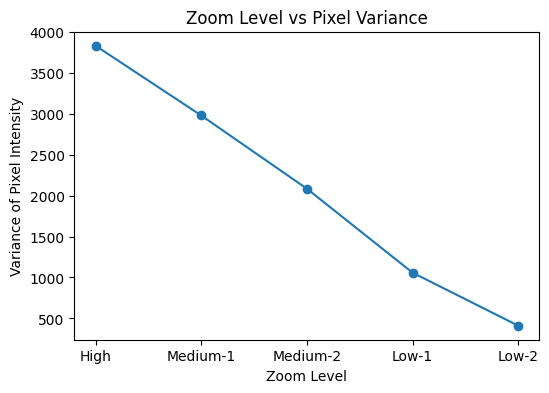

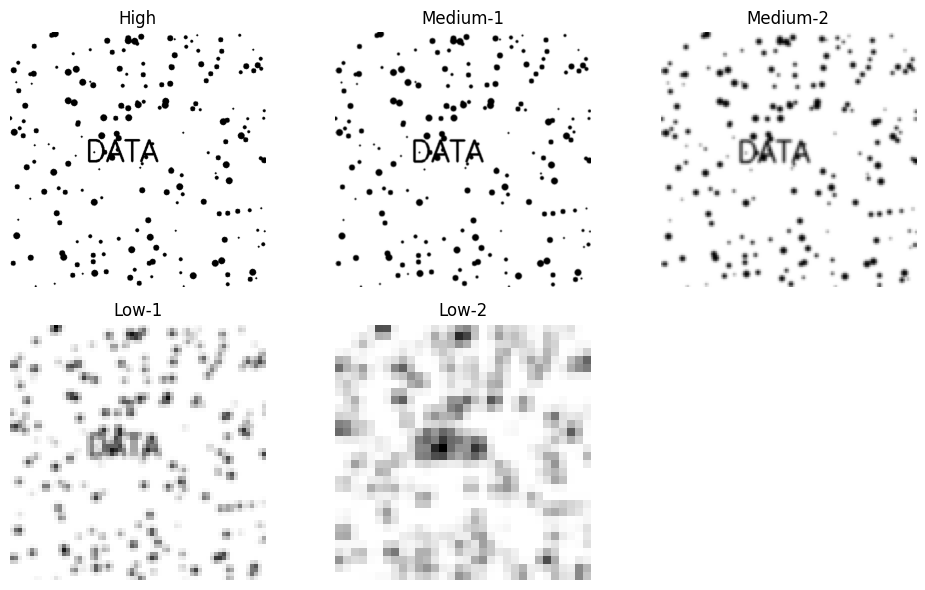

In [5]:
# Install required libraries
!pip install opencv-python matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Create base high-resolution textured image
# -------------------------------------------------
base = np.ones((512, 512), dtype=np.uint8) * 255

# Add patterns for texture
cv2.putText(base, "DATA", (150, 260),
            cv2.FONT_HERSHEY_SIMPLEX, 2, 0, 4)

for i in range(200):
    cv2.circle(base,
               (np.random.randint(0,512),
                np.random.randint(0,512)),
               np.random.randint(2,8),
               0, -1)

# -------------------------------------------------
# 2. Generate different resolution versions
# -------------------------------------------------
img_high = base
img_med1 = cv2.pyrDown(img_high)
img_med2 = cv2.pyrDown(img_med1)
img_low1 = cv2.pyrDown(img_med2)
img_low2 = cv2.pyrDown(img_low1)

images = [img_high, img_med1, img_med2, img_low1, img_low2]
labels = ["High", "Medium-1", "Medium-2", "Low-1", "Low-2"]

# -------------------------------------------------
# 3. Compute Mean and Variance
# -------------------------------------------------
means = []
variances = []

for img in images:
    flat = img.flatten()
    means.append(np.mean(flat))
    variances.append(np.var(flat))

# Print results
print("Zoom Level | Mean Intensity | Variance")
for i in range(len(labels)):
    print(f"{labels[i]:10} | {means[i]:14.2f} | {variances[i]:.2f}")

# -------------------------------------------------
# 4. Plot Zoom Level vs Variance
# -------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(labels, variances, marker='o')
plt.title("Zoom Level vs Pixel Variance")
plt.xlabel("Zoom Level")
plt.ylabel("Variance of Pixel Intensity")
plt.show()

# -------------------------------------------------
# 5. Display Images for Visual Comparison
# -------------------------------------------------
plt.figure(figsize=(10,6))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis("off")

plt.tight_layout()
plt.show()
